# ECON 570 Assignment 2
# Virat Agrawal 
### USC ID: 1118-9938-42

### Repository: https://github.com/viratagr/Assignment2-Econ570-Spring2022.git

In [318]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import graphviz as gr

from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [319]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [320]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

In [321]:
def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

In [322]:
def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [323]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [324]:
def fn_generate_data(tau,N,p,p0,corr,conf,flagX):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar) # generate a matrix of Xs
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates (it incudes some Xs out of matrix of Xs)
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err # Outcome equation
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:#flagX == False means no Xs included
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:# flagX == 1 means it uses the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:# if flagX==2 means that it uses some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    # plots X against Y
    # The label is what comes out in legend
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    # axhline is teh horizontal line at the true value of tau
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    # fill confidence interval
    # Alpha is the opacity of teh color fill
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

## Part 1

Baicker, Katherine; Taubman, Sarah L.; Allen, Heidi L.; Bernstein, Mira; Gruber, Jonathan H.; Newhouse, Joseph P.; Schneider, Eric C.; Wright, Bill J.; Zaslavsky, Alan M.; Finkelstein, Amy N. (2013) "The Oregon Experiment — Effects of Medicaid on Clinical Outcomes." New England Journal of Medicine. Volume 368-18, pg 1713-1722

Introduction: In 2008, Oregon initiated a limited expansion of its Medicaid program for low-income adults through a lottery drawing of approximately 30,000 names from a waiting list of almost 90,000 persons. Selected adults won the opportunity to apply for Medicaid and to enroll if they met eligibility requirements. This lottery presented an opportunity to study the effects of Medicaid with the use of random assignment.

## 1A. No Covariates

$y_i = \tau*T_i+e_i$

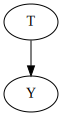

In [325]:
g = gr.Digraph()
g.edge("T", "Y")

g

### Example: Oregon Experiment. 
T: Random Enrollment in Medicaid
Y: Health Outcome

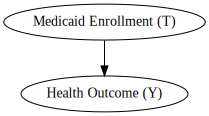

In [326]:
g = gr.Digraph()
g.edge("Medicaid Enrollment (T)", "Health Outcome (Y)")

g

In [327]:
tau = 0.2
corr = 0.5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,5) # loop over N values
flagX = False
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


100%|████████████████████████████████████████| 198/198 [00:00<00:00, 303.26it/s]


In [328]:
data_1a_dgp = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats=tauhats,
                         sehats=sehats,
                         lb=lb,
                         ub=ub))
                  
data_1a_dgp.to_csv("/Users/viratagrawal/Documents/USC-PhD-Public Policy/Spring 2022/ECON-570/Problem Set 2/data_1a_dgp.csv", index=False)

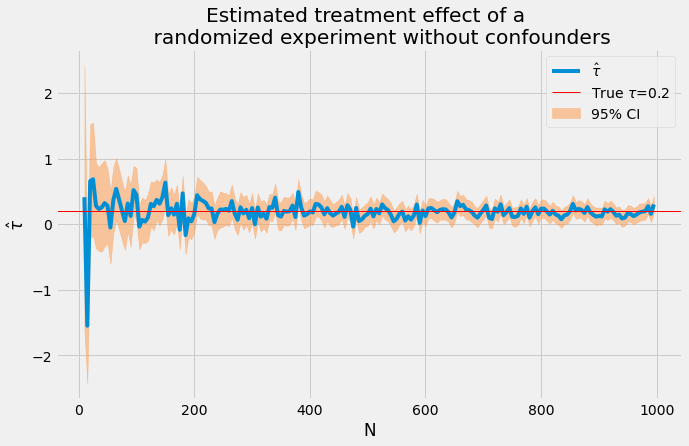

In [329]:
caption = """Estimated treatment effect of a 
    randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

### Now, Run R Monte Carlo iterations and compute bias, RMSE and size for N = 100 & 1000

In [330]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 134.69it/s]


In [331]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=0.0006039698442155887, RMSE=0.2003278329269466, Size=0.051
N=1000: Bias=0.0008233236936178001, RMSE=0.06356964176521078, Size=0.0545


In the above result, we see that RMSE is lower for higher N.
Size converges to 5% significance level

## 1B. With Covariates (Xs)
$y_i = \tau*T_i+\beta1*X_i+e_i$

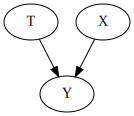

In [332]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")

g

### Example: As discissed in Part 1A - The Oregon Medicaid Enrollment Experiment.
We can add covariates (Age, Gender, Race and Language Speak) in the model
$y_i = \tau*T_i+\beta1*X1_i+\beta2*X2_i+\beta3*X3_i+\beta4*X4_i+e_i$

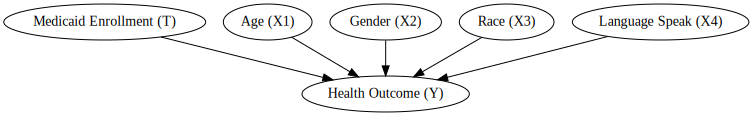

In [333]:
g = gr.Digraph()
g.edge("Medicaid Enrollment (T)", "Health Outcome (Y)")
g.edge("Age (X1)", "Health Outcome (Y)")
g.edge("Gender (X2)", "Health Outcome (Y)")
g.edge("Race (X3)", "Health Outcome (Y)")
g.edge("Language Speak (X4)", "Health Outcome (Y)")

g

In [334]:
tau = 0.2
corr = 0.5
conf=False
p = 10
p0 = 20 # number of covariates used in the DGP
Nrange = range(10,1000,5) # loop over N values
flagX = 1 # Using flagX = 1 because I want to use all right covariates
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 198/198 [00:01<00:00, 148.86it/s]


In [335]:
data_1b_dgp = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats=tauhats,
                         sehats=sehats,
                         lb=lb,
                         ub=ub))
                  
data_1b_dgp.to_csv("/Users/viratagrawal/Documents/USC-PhD-Public Policy/Spring 2022/ECON-570/Problem Set 2/data_1b_dgp.csv", index=False)

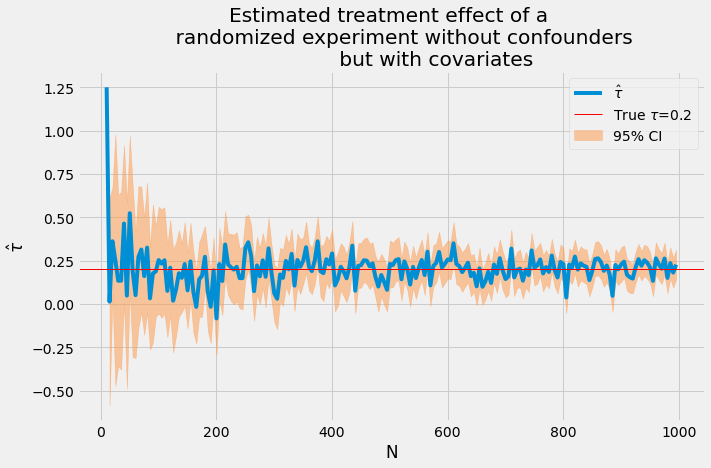

In [336]:
caption = """Estimated treatment effect of a 
    randomized experiment without confounders
              but with covariates"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

###### The plot with Xs, when flagX is equal to 1, gives noisy output
This shows that adding Xs introduce noise

#### Now, Run R Monte Carlo iterations and compute bias, RMSE and size for N = 100 & 1000

In [337]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 133.36it/s]


In [338]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=-0.20716123032325356, RMSE=7.869969431297839, Size=0.0485
N=1000: Bias=-0.05448285839238943, RMSE=2.5751147065751403, Size=0.054


In the above result, we see that RMSE is lower for higher N.
Size converges to 5% significance level. Bias has increased after adding covariates

## Part 2 - Confounder

## 2A. No Covariates

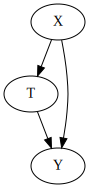

In [339]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "T")

g

### Example: 
During the early days of the COVID-19 pandemic, due to the novelity of this disease our healthcare professionals were not very familiar with the type of treatment that would work best on critically ill COVID-19 patients. During that time doctors were trying different approaches and it was a learning curve for them too. The drug "Remdesivir" seemed somewhat effective on critically-ill COVID-19 patients. As the drug given emergency approval by the FDA for use only on critically ill adults, any estimate on the effectiveness of the drug without controlling for the COVID-19 illness severity would give a biased estimate. It is because the drug was only used on critically ill patients who had little chance to survive, and the illness itself is affecting the chances of survival. (Please see the causal graph below).  
Here the severity of illness of COVID-19 patients is a confounder because it influences both the likelihood of using Remdesivir as the treatment and the survival rate. There are several common cofounding factors in health related research:
a) Severity of disease: Discussed above
b) Access to healthcare: It impacts both the illness and treatment
c) Healthy user/adherence bias: People who are more disciplined are more likely to adhere to medicine, workout, diet.

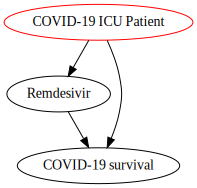

In [340]:
g = gr.Digraph()
g.edge("Remdesivir", "COVID-19 survival")
g.edge("COVID-19 ICU Patient", "COVID-19 survival"), g.node("COVID-19 ICU Patient", color="red")
g.edge("COVID-19 ICU Patient", "Remdesivir")

g

In [341]:
tau = 0.2
corr = 0.5
conf=True # Adding Confounder
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,5) # loop over N values
flagX = False # No covariates
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 198/198 [00:00<00:00, 253.55it/s]


In [342]:
data_2a_dgp = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats=tauhats,
                         sehats=sehats,
                         lb=lb,
                         ub=ub))
                  
data_2a_dgp.to_csv("/Users/viratagrawal/Documents/USC-PhD-Public Policy/Spring 2022/ECON-570/Problem Set 2/data_2a_dgp.csv", index=False)

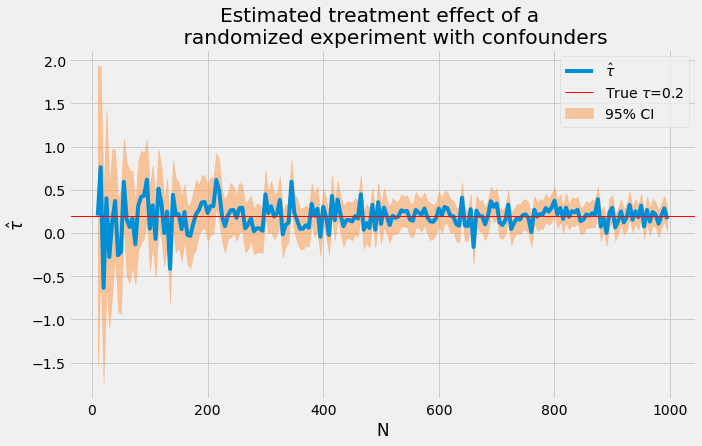

In [343]:
caption = """Estimated treatment effect of a 
    randomized experiment with confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

#### Now, Run R Monte Carlo iterations and compute bias, RMSE and size for N = 100 & 1000

In [344]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 119.72it/s]


In [345]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=-0.0015728267915231999, RMSE=0.22965302765971185, Size=0.055
N=1000: Bias=0.003341632774246426, RMSE=0.07516318689590325, Size=0.06


In the above result, we see that RMSE is lower for higher N.
Size converges to 5% significance level. 
Bias in this model (confounder, no covariate) has increased a little bit compared to the first model (no confounder, no covariate)

## 2B. Controlling for Confounder

#### Here the confounder is the severity of COVID-19 ICU patients. Factors like age, pre-existing conditions like diabetes, obesity, cardiovascular disease are strong predictors of severity, so we will control for these factors

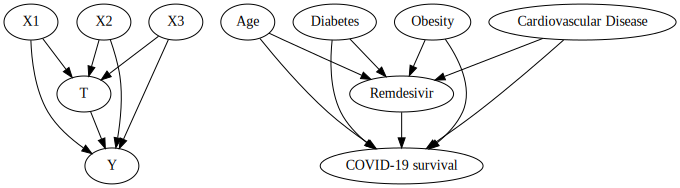

In [346]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X1", "T")
g.edge("X2", "T")
g.edge("X3", "T")
g.edge("X1", "Y")
g.edge("X2", "Y")
g.edge("X3", "Y")


g.edge("Remdesivir", "COVID-19 survival")
g.edge("Age", "Remdesivir")
g.edge("Diabetes", "Remdesivir")
g.edge("Obesity", "Remdesivir")
g.edge("Cardiovascular Disease", "Remdesivir")
g.edge("Age", "COVID-19 survival")
g.edge("Diabetes", "COVID-19 survival")
g.edge("Obesity", "COVID-19 survival")
g.edge("Cardiovascular Disease", "COVID-19 survival")


g

In [347]:
tau = 0.2
corr = 0.5
conf=True # Adding Confounder
p = 10
p0 = 20 # number of covariates used in the DGP
Nrange = range(10,1000,5) # loop over N values
flagX = 1 # Using flagX = 1 because I want to use all right covariates
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 198/198 [00:01<00:00, 181.07it/s]


In [348]:
data_2b_dgp = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats=tauhats,
                         sehats=sehats,
                         lb=lb,
                         ub=ub))
                  
data_2b_dgp.to_csv("/Users/viratagrawal/Documents/USC-PhD-Public Policy/Spring 2022/ECON-570/Problem Set 2/data_2b_dgp.csv", index=False)

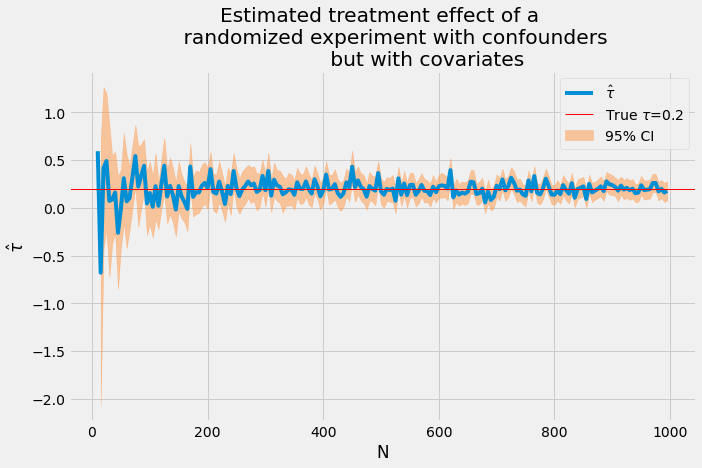

In [349]:
caption = """Estimated treatment effect of a 
    randomized experiment with confounders
              but with covariates"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

On comparison of above plot with the one without covariates we see that adding covaraites has increased noise

#### Now, Run R Monte Carlo iterations and compute bias, RMSE and size for N = 100 & 1000

In [350]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 134.30it/s]


In [351]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=-0.005467082682446432, RMSE=7.898117653454741, Size=0.0455
N=1000: Bias=0.05776120515575701, RMSE=2.5476757808359856, Size=0.044


In the above result, we see that RMSE is lower for higher N.
Size converges to 5% significance level. 
Bias in this model (confounder, with covariate) has increased compared to the last model (confounder, no covariate)

##  Part 3 - Selection Bias

### A: No Covariates

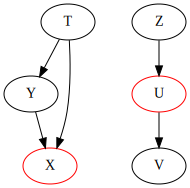

In [352]:
g = gr.Digraph()
g.edge("T", "Y"), g.node("X", color="red")
g.edge("T", "X")
g.edge("Y", "X")

g.edge("Z", "U"), g.node("U", color="red")
g.edge("U", "V")

g

Selelction Bias: Controlling for a variable that is either in between the treatment and the outcome or is a common effect of the outcome and the treated.

##  Example: Below

If we estimate the effect of covid-19 vaccination on mental health outcome - anxiety and depression, there would be selection bias because of controlling for Covid-19 vaccination. More anxious people are more likley to get vaccinated, therefore, vaccination is affected by anxiety. In conclusion, the receipt of covid-19 vaccine is endogenous as more anxious people are more likley to get vaccinated.

This selection bias due to endogeneity of Covid-19 vaccine uptake can be solved by using an instrumental variable (an exogenous variable). Here, we use vaccine eligibility as the instrument because eligibility is an age based state-policy, which is exogenous and not influenced by individuals anxiety, beliefs towards vaccine etc. So we estimate the effect of eligibilty criteria on covid vaccination, and then use the predicted value of vaccination to estimate the impact on  Anxiety/Depression. 

Please see the below paper for more details:
Agrawal, Virat, Jonathan H. Cantor, Neeraj Sood, & Christopher M. Whaley. (2021). “The Impact of the COVID-19 Vaccine Distribution on Mental Health Outcomes.” National Bureau of Economic Research, Working Paper:29593

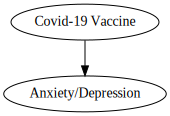

In [353]:
# Selection Bias
g = gr.Digraph()
g.edge("Covid-19 Vaccine", "Anxiety/Depression")

g

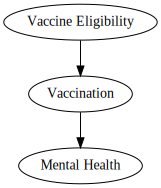

In [354]:
# Solving Selection Bias using exogenous Vaccine Eligibility Policy
g = gr.Digraph()

g.edge("Vaccine Eligibility", "Vaccination")
g.edge("Vaccination", "Mental Health")

g

####  Exploiting only T (eligibility) --> X (Vaccination) --> Y (Anxiety/Depression) pathway

## DGP: 
The causal impact of U (Vaccine) on V (mental Health). Z (Vaccine Eligibility) is not included. Therefore, Selection Bias

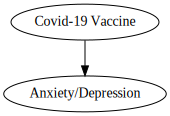

In [355]:
g = gr.Digraph()
g.edge("Covid-19 Vaccine", "Anxiety/Depression")

g

## I need to Generate a Data that has Selection Bias.
A non-random treatment function, where there are more 1s and less 0s. And Treatmnet = 1 is correlated with Outcome

In [356]:
# Creating a new random treatment (P for treatment (getting vaccine) is 0.4. 
# changed form 0.5 to 0.4 because getting vaccine is not completey random 
def fn_randomize_treatment_2(N,p=0.4):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [357]:
# As discussed above, Creating a sightly differnet Data Generate Function (Version 2 for this problem):

def fn_generate_data_2(tau,N,p,p0,corr,conf,flagX):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar) # generate a matrix of Xs
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates (it incudes some Xs out of matrix of Xs)
    
    T = fn_randomize_treatment_2(N) # Treatment
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err # Outcome equation
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

In [358]:
# Creating a sightly differnet Run Experiment Function (Version 2 for this problem):

def fn_run_experiments_2(tau,Nrange,p,p0,corr,conf,flagX):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:#flagX == False means no Xs included
            Yexp,T = fn_generate_data_2(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:# flagX == 1 means it uses the right covariates in regression
            Yexp,T,X = fn_generate_data_2(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:# if flagX==2 means that it uses some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data_2(tau,N,p,p0,corr,conf,flagX) # Using version 2 data generate function
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

In [359]:
tau = 0.2
corr = 0.8 # Changed correlation to 0.8 from 0.5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,5) # loop over N values
flagX = False
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments_2(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 198/198 [00:00<00:00, 296.13it/s]


In [360]:
data_3a_dgp = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats=tauhats,
                         sehats=sehats,
                         lb=lb,
                         ub=ub))
                  
data_3a_dgp.to_csv("/Users/viratagrawal/Documents/USC-PhD-Public Policy/Spring 2022/ECON-570/Problem Set 2/data_3a_dgp.csv", index=False)

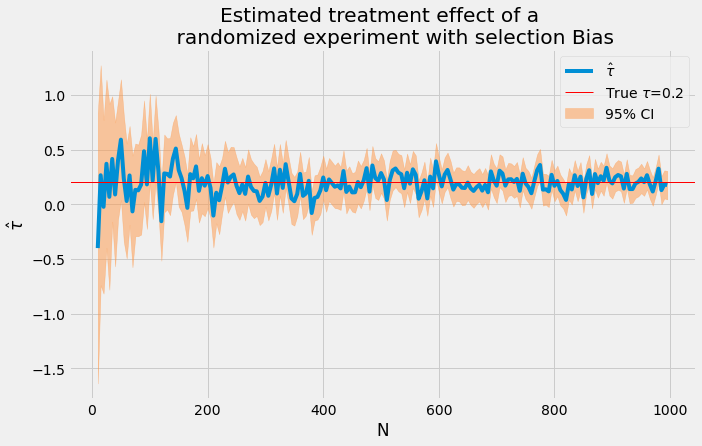

In [361]:
caption = """Estimated treatment effect of a 
    randomized experiment with selection Bias"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

#### Now, Run R Monte Carlo iterations and compute bias, RMSE and size for N = 100 & 1000

In [362]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data_2(tau,N,p,p0,corr,conf,flagX) #Using generate_date_2 function
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 141.27it/s]


In [363]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=-0.006429765228097686, RMSE=0.20910888215656104, Size=0.0635
N=1000: Bias=0.0005587133152952795, RMSE=0.06446500052010427, Size=0.049


### Selection Bias (Adding Covariates)

In [364]:
tau = 0.2
corr = 0.5
conf=False
p = 10
p0 = 20 # number of covariates used in the DGP
Nrange = range(10,1000,5) # loop over N values
flagX = 1 # Using flagX = 1 because I want to use all right covariates
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 198/198 [00:01<00:00, 180.57it/s]


In [365]:
data_3a_covariates_dgp = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats=tauhats,
                         sehats=sehats,
                         lb=lb,
                         ub=ub))
                  
data_3a_covariates_dgp.to_csv("/Users/viratagrawal/Documents/USC-PhD-Public Policy/Spring 2022/ECON-570/Problem Set 2/data_3a_covariates_dgp.csv", index=False)

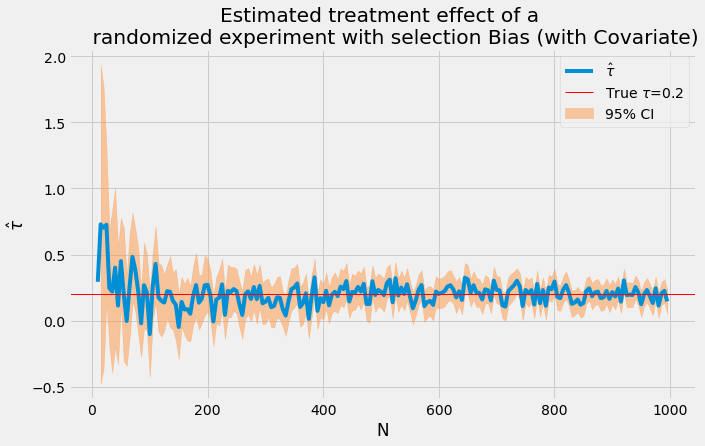

In [366]:
caption = """Estimated treatment effect of a 
    randomized experiment with selection Bias (with Covariate)"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

As we see in the above plot, noise has increased a lot after adding covariates

In [367]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data_2(tau,N,p,p0,corr,conf,flagX) #Using generate_date_2 function
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 110.77it/s]


In [368]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=0.019579487054937745, RMSE=8.142299675855355, Size=0.0485
N=1000: Bias=0.1541142201778205, RMSE=2.664476299208043, Size=0.056


Comapred to selection Bias (no covariate), bias is high in selection bias (with covariate)
RMSE decreases with increase in N
Size converges to 5% significance level.

### B: Using Instrument "Covid-19 Vaccine Eligibility" and Covariates
Age, Gender, Race, Education, Marital Status, and Income

First Order:
$Vaccine_i = \tau*Eligibility_i+\beta1*age_i+\beta2*gender_i+\beta3*race_i+\beta4*educ_i+\beta5*income_i+\beta6*marriage_i+e_i$

Second Order:
$Mental-Health_i = \gamma*Vaccine-hat+\delta1*age_i+\delta2*gender_i+\delta3*race_i+\delta4*educ_i+\delta5*income_i+\delta6*marriage_i+u_i$


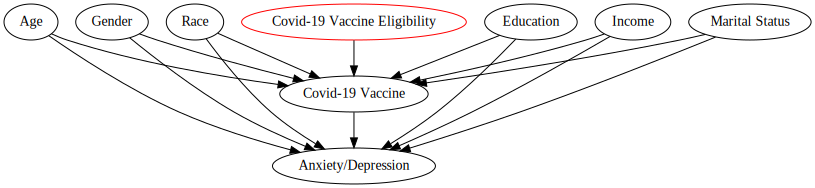

In [371]:
g = gr.Digraph()
g.edge("Covid-19 Vaccine Eligibility", "Covid-19 Vaccine"), g.node("Covid-19 Vaccine Eligibility", color="red")
g.edge("Covid-19 Vaccine", "Anxiety/Depression")
g.edge("Age", "Anxiety/Depression")
g.edge("Gender", "Anxiety/Depression")
g.edge("Race", "Anxiety/Depression")
g.edge("Education", "Anxiety/Depression")
g.edge("Income", "Anxiety/Depression")
g.edge("Marital Status", "Anxiety/Depression")
g.edge("Age", "Covid-19 Vaccine")
g.edge("Gender", "Covid-19 Vaccine")
g.edge("Race", "Covid-19 Vaccine")
g.edge("Education", "Covid-19 Vaccine")
g.edge("Income", "Covid-19 Vaccine")
g.edge("Marital Status", "Covid-19 Vaccine")

g

## Now I am trying a Basic IV method - Concept:
#### First Stage: $X = \alpha1 +\delta*Z+e1$
#### Second stage: $Y = \alpha2 +\lambda*Z+e2$ 
#### Reduced form: $Y = \alpha3 +\theta*Z+e3$ 
### I want to calculate lambda = theta / delta
#### The coefficient "Theta" comes from reduced form equation (i.e. the impact of  Z on Y)
#### The coefficient "Delta" comes from first stage equation (i.e. the impact of  Z on X)
#### Dividing the estiamte of reduced form by teh estimate of first stage gives the estimate of second stage (i.e. the impact of X-hat on Y)

In [372]:
# Creating a new random treatment (P for treatment (vaccine eligibility) is 0.3)
def fn_randomize_treatment_3(N,p=0.3):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [373]:
def fn_tauhat_means_X(Xt,Xc):
    nt = len(Xt)
    nc = len(Xc)
    tauhat_X = np.mean(Xt)-np.mean(Xc)
    se_tauhat_X = (np.var(Xt,ddof=1)/nt+np.var(Xc,ddof=1)/nc)**(1/2)
    return (tauhat_X,se_tauhat_X)

In [374]:
# As discussed above, Creating a sightly differnet Data Generate Function (Version 2 for this problem):

def fn_generate_data_3(tau,gamma,N,p,p0,corr,conf,flagX):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar) # generate a matrix of Xs
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates (it incudes some Xs out of matrix of Xs)
    
    T = fn_randomize_treatment_3(N) # Treatment is Eligibility
    #Z = fn_randomize_eligibility(N) # Eligibility
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    beta1 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    beta1[p0:p] = 0 # sparse model
    Yexp = tau*T+X@beta0+conf_mult*0.6*C+err # Outcome equation
    
    Xexp = gamma*T+X@beta1+conf_mult*0.6*C+err # First Order equation (Predict X-hat using instrument z)
    
    if flagX==False:
        return (Yexp,T,Xexp)
    else:
        return (Yexp,T,X,Xexp)

In [375]:
# Creating a sightly differnet Run Experiment Function (Version 2 for this problem):

def fn_run_experiments_3(tau,gamma,Nrange,p,p0,corr,conf,flagX):
    n_values = []
    tauhats_Y = []
    sehats_Y = []
    lb_Y = []
    ub_Y = []
    tauhats_X = []
    sehats_X = []
    lb_X = []
    ub_X = []
    
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:#flagX == False means no Xs included
            Yexp,T,Xexp = fn_generate_data_3(tau,gamma,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat_Y,se_tauhat_Y = fn_tauhat_means(Yt,Yc)
            Xt = Xexp[np.where(T==1)[0],:]
            Xc = Xexp[np.where(T==0)[0],:]
            tauhat_X,se_tauhat_X = fn_tauhat_means_X(Xt,Xc)
        elif flagX==1:# flagX == 1 means it uses the right covariates in regression
            Yexp,T,X,Xexp = fn_generate_data_3(tau,gamma,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod_Y = sm.OLS(Yexp,covars)
            res_Y = mod_Y.fit()
            tauhat_Y = res_Y.params[0]
            se_tauhat_Y = res_Y.HC1_se[0]
            mod_X = sm.OLS(Xexp,covars)
            res_X = mod_X.fit()
            tauhat_X = res_X.params[0]
            se_tauhat_X = res_X.HC1_se[0]
        elif flagX==2:# if flagX==2 means that it uses some of the right covariates and some "wrong" ones
            Yexp,T,X,Xexp = fn_generate_data_3(tau,gamma,N,p,p0,corr,conf,flagX) # Using version 2 data generate function
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod_Y = sm.OLS(Yexp,covars)
            res_Y = mod_Y.fit()
            tauhat_Y = res_Y.params[0]
            se_tauhat_Y = res_Y.HC1_se[0]
            mod_X = sm.OLS(Xexp,covars)
            res_X = mod_X.fit()
            tauhat_X = res_X.params[0]
            se_tauhat_X = res_X.HC1_se[0]
            
        tauhats_Y = tauhats_Y + [tauhat_Y]
        sehats_Y = sehats_Y + [se_tauhat_Y]    
        lb_Y = lb_Y + [tauhat_Y-1.96*se_tauhat_Y]
        ub_Y = ub_Y + [tauhat_Y+1.96*se_tauhat_Y]
    
        tauhats_X = tauhats_X + [tauhat_X]
        sehats_X = sehats_X + [se_tauhat_X]    
        lb_X = lb_X + [tauhat_X-1.96*se_tauhat_X]
        ub_X = ub_X + [tauhat_X+1.96*se_tauhat_X]
        
    return (n_values,tauhats_Y,sehats_Y,lb_Y,ub_Y,tauhats_X,sehats_X,lb_X,ub_X)

In [376]:
tau = 0.2 # The estimated effect of Treatment on Y (Reduced form)
gamma = 0.4 # The estimated effect of Treatment on X (First Stage form)
corr = 0.5
conf=False
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,5) # loop over N values
flagX = 1 # Using flagX = 1 because I want to use all right covariates
(n_values,tauhats_Y,sehats_Y,lb_Y,ub_Y,tauhats_X,sehats_X,lb_X,ub_X) = fn_run_experiments_3(tau,gamma,Nrange,p,p0,corr,conf,flagX)

100%|████████████████████████████████████████| 198/198 [00:00<00:00, 226.82it/s]


In [377]:
data_3b_iv_dgp = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats_Y=tauhats_Y,
                         sehats_Y=sehats_Y,
                         lb_Y=lb_Y,
                         ub_Y=ub_Y,
                         tauhats_X=tauhats_X,
                         sehats_X=sehats_X,
                         lb_X=lb_X,
                         ub_X=ub_X))
                  
data_3b_iv_dgp.to_csv("/Users/viratagrawal/Documents/USC-PhD-Public Policy/Spring 2022/ECON-570/Problem Set 2/data_3b_iv_dgp.csv", index=False)

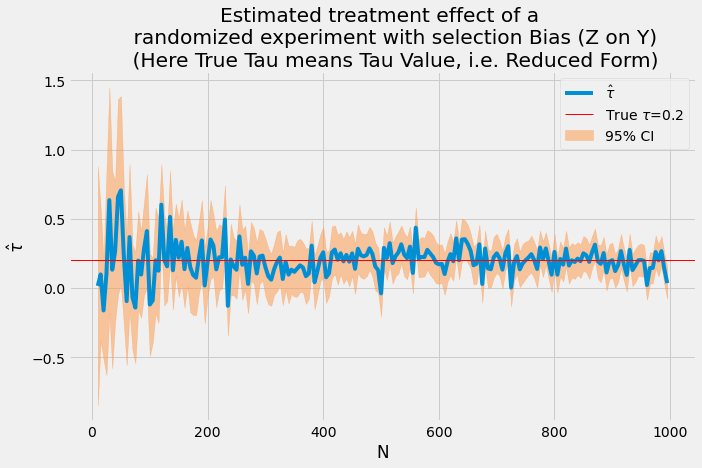

In [381]:
caption = """Estimated treatment effect of a 
    randomized experiment with selection Bias (Z on Y)
    (Here True Tau means Tau Value, i.e. Reduced Form)"""
fn_plot_with_ci(nvalues,tauhats_Y,tau,lb_Y,ub_Y,caption)

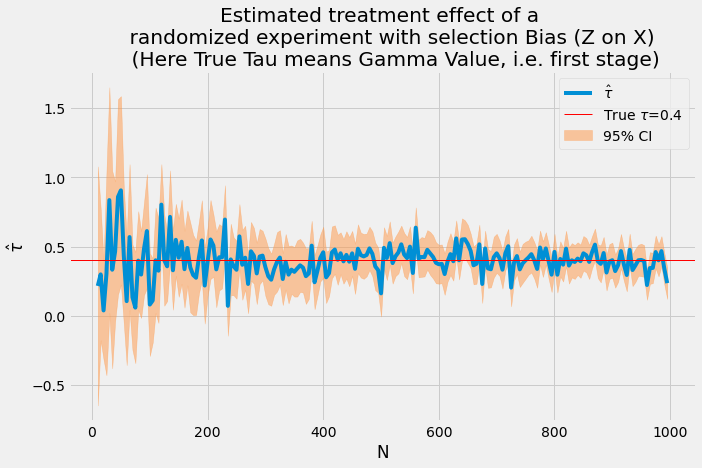

In [382]:
caption = """Estimated treatment effect of a 
    randomized experiment with selection Bias (Z on X) 
    (Here True Tau means Gamma Value, i.e. first stage)"""
fn_plot_with_ci(nvalues,tauhats_X,gamma,lb_X,ub_X,caption)

### Monte Carlo

In [383]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats_Y = []
    sehats_Y = []
    tauhats_X = []
    sehats_X = []
    for r in tqdm(range(R)):
        Yexp,T,X,Xexp = fn_generate_data_3(tau,gamma,N,p,p0,corr,conf,flagX) #Using generate_date_2 function
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat_Y,se_tauhat_Y = fn_tauhat_means(Yt,Yc)
        Xt = Xexp[np.where(T==1)[0],:]
        Xc = Xexp[np.where(T==0)[0],:]
        tauhat_X,se_tauhat_X = fn_tauhat_means_X(Xt,Xc)
        tauhats_Y = tauhats_Y + [tauhat_Y]
        sehats_Y = sehats_Y + [se_tauhat_Y]
        tauhats_X = tauhats_X + [tauhat_X]
        sehats_X = sehats_X + [se_tauhat_X]
        
    estDict[N] = {
        'tauhat_Y':np.array(tauhats_Y).reshape([len(tauhats_Y),1]),
        'sehat_Y':np.array(sehats_Y).reshape([len(sehats_Y),1]),
        'tauhat_X':np.array(tauhats_X).reshape([len(tauhats_X),1]),
        'sehat_X':np.array(sehats_X).reshape([len(sehats_X),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:13<00:00, 153.37it/s]


Bias, RMSE and Size (the effect of Treatment (eligibility) on Y (Anxiety/Depression)

In [384]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat_Y'],
                                         results['sehat_Y'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=8.656120148474877e-05, RMSE=0.21161873885779864, Size=0.0585
N=1000: Bias=-0.002223329859213668, RMSE=0.06924372730346505, Size=0.0515


Bias, RMSE and Size (the effect of Treatment (Eligibility) on X (Getting Vaccinated)

In [385]:
gammma0 = gamma*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat_X'],
                                         results['sehat_X'])
    print(f'N={N}: Bias={bias}, RMSE={rmse}, Size={size}')

N=100: Bias=0.20008656120148477, RMSE=0.2912337808640321, Size=0.146
N=1000: Bias=0.19777667014078634, RMSE=0.20953606330937682, Size=0.8115


### As discussed earlier, if we calculate the the reduced form estimate (Y) and First Stage estimate (X), we can calculate second stage estimate. See the IV concept below.
#### First Stage: $X = \alpha1 +\delta*Z+e1$
#### Second stage: $Y = \alpha2 +\lambda*Z+e2$ 
#### Reduced form: $Y = \alpha3 +\theta*Z+e3$ 
### I want to calculate lambda = theta / delta
#### The coefficient "Theta" comes from reduced form equation (i.e. the impact of  Z on Y)
#### The coefficient "Delta" comes from first stage equation (i.e. the impact of  Z on X)
#### Dividing the estiamte of reduced form by teh estimate of first stage gives the estimate of second stage (i.e. the impact of X-hat on Y)